Here we gonna build CharLM, which takes $k$ previous **words** (not characters) and predicts the next word **symbol by symbol**. The only problem here is to generate the vocabs.

In [1]:
import sys; sys.path += ['..', '../src']

In [2]:
% load_ext autoreload
% autoreload 2

In [3]:
import os
from itertools import islice

from src.vocab import Vocab

DATA_PATH = '../data/generated'
DUMMY_CHAR = 0
min_len = 10
max_len = 20

train_path = os.path.join(DATA_PATH, 'train.en.tok.bpe')
train = open(train_path, 'r', encoding='utf-8').read().splitlines()
train = [s for s in train if len(s.split()) < max_len]

vocab = Vocab.from_sequences(train)
train_idx = [[vocab.token2id[t] for t in s.split()] for s in train]

In [4]:
# Let's currently use free GPU, which I've found on the server
# %env CUDA_VISIBLE_DEVICES=3

In [5]:
%matplotlib inline

import os
import torch
import torch.nn as nn
from torch.optim import Adam

from src.models import TransformerLM
from src.dataloaders import OneSidedDataloader
from src.utils.common import variable
from src.vocab import constants
from src.trainers import LMTrainer

log_file_path = '../logs/lm.log'

# Let's clean log file
if os.path.exists(log_file_path): os.remove(log_file_path)

def reconstruction_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)

transformer_kwargs = {
    'n_head': 4,
    'n_layers': 4,
    'd_model': 256,
    'd_word_vec': 256,
    'd_inner_hid': 512
}
transformer = TransformerLM(len(vocab), max_len, **transformer_kwargs)
optimizer = Adam(transformer.trainable_parameters(), lr=1e-4)
criterion = reconstruction_criterion(len(vocab))

config = {
    'max_num_epochs': 10,
    'plot_every': 1
}

training_data = OneSidedDataloader(train_idx[:4], batch_size=2, shuffle=False)
trainer = LMTrainer(transformer, optimizer, criterion, vocab, config)

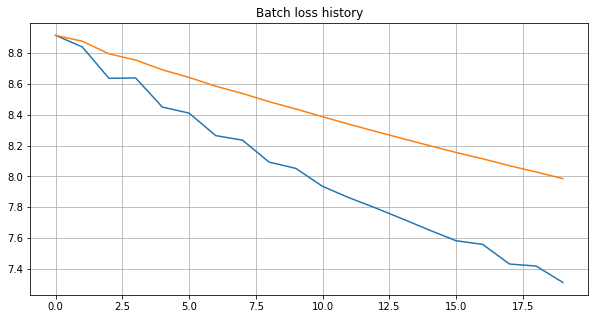

In [6]:
trainer.run_training(training_data, None)

Let's run our transformer on news corpus. Inference is not that easy, because we are predicting word-by-word

In [101]:
torch.save(transformer.state_dict(), '../trained_models/transformer_lm.pth')